
🌲 Integrated Forest Fire Risk System
Enter center latitude: 25.6154
Enter center longitude: 85.1010
Enter OpenWeatherMap API key: a1f86c04ecc3d27f1f5f6118c0b80ce6
📍 Area: Patna, Patna Rural, Patna, Bihar, 800001, India

🌤️ Weather: Temp=34.18 °C, Humidity=47%, Wind=4.73 m/s, Direction=E

🎯 Accuracy: 0.99


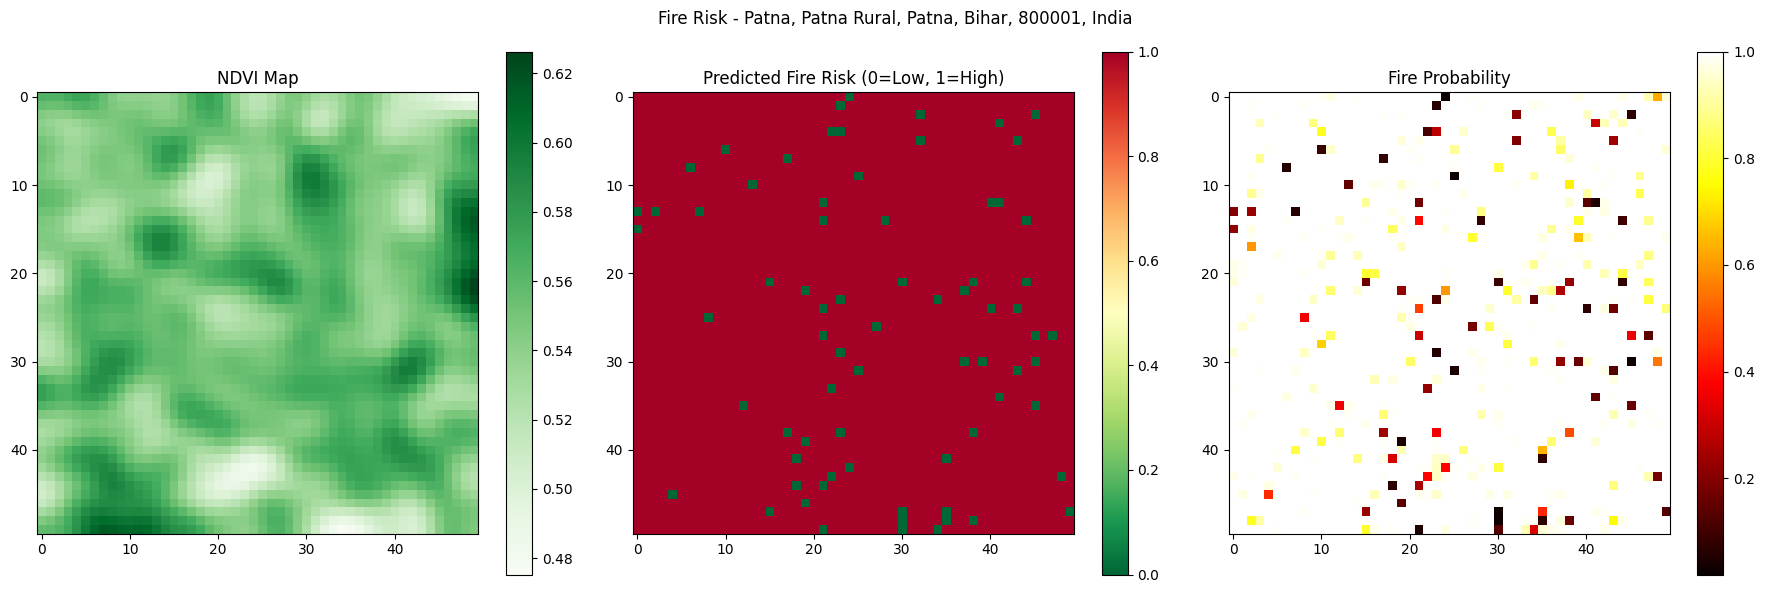


✅ Map saved as hybrid_fire_map.html


In [10]:
# 🔁 Integrated Forest Fire Prediction System

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# 🔹 Reverse Geocoding Utility

def get_area_name(lat, lon):
    try:
        url = f"https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat={lat}&lon={lon}"
        headers = {'User-Agent': 'ForestFirePredictor/1.0'}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            return data.get("display_name", "Unknown Area")
    except:
        pass
    return "Unknown Area"

# 🔹 Wind Direction Utility

def get_wind_direction(degrees):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    idx = int((degrees + 22.5) % 360 / 45)
    return directions[idx]

# 🔹 Weather API Class
class ForestWeatherAPI:
    def __init__(self):
        self.apis = {
            'openweather': 'https://api.openweathermap.org/data/2.5/weather'
        }

    def get_openweather_data(self, lat, lon, api_key):
        url = f"{self.apis['openweather']}?lat={lat}&lon={lon}&appid={api_key}&units=metric"
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                data = r.json()
                return {
                    'temp': data['main']['temp'],
                    'humidity': data['main']['humidity'],
                    'wind_speed': data['wind']['speed'],
                    'wind_deg': data['wind'].get('deg', 0),
                    'source': 'OpenWeatherMap'
                }
        except:
            return None
        return None

    def get_weather_data(self, lat, lon, api_keys):
        if api_keys.get('openweather'):
            return self.get_openweather_data(lat, lon, api_keys['openweather'])
        return {'temp': 35.0, 'humidity': 30.0, 'wind_speed': 5.0, 'wind_deg': 0, 'source': 'Default'}

# 🔹 Fire Prediction System
class ForestFirePredictor:
    def __init__(self):
        self.model = None
        self.weather_api = ForestWeatherAPI()

    def calculate_fire_risk_score(self, ndvi, temp, humidity, wind_speed):
        veg_factor = max(0.1, min(0.9, (ndvi - 0.3) / 0.6))
        weather_factor = 0
        if temp > 25:
            weather_factor += min(0.5, (temp - 25) / 15)
        if humidity < 60:
            weather_factor += min(0.4, (60 - humidity) / 50)
        if wind_speed > 3:
            weather_factor += min(0.3, (wind_speed - 3) / 10)
        return min(1.0, veg_factor * 0.6 + weather_factor * 0.4)

    def generate_training_data(self, grid_size, weather_data, ndvi_grid, center_lat, center_lon):
        np.random.seed(42)
        data = []
        lat_range = 0.1
        lon_range = 0.1
        lat_step = lat_range / grid_size
        lon_step = lon_range / grid_size
        lat_start = center_lat - lat_range / 2
        lon_start = center_lon - lon_range / 2

        for i in range(grid_size):
            for j in range(grid_size):
                ndvi = ndvi_grid[i, j]
                temp = weather_data['temp'] + np.random.normal(0, 2)
                humidity = weather_data['humidity'] + np.random.normal(0, 5)
                wind_speed = weather_data['wind_speed'] + np.random.normal(0, 1)
                risk = self.calculate_fire_risk_score(ndvi, temp, humidity, wind_speed)
                label = 1 if risk > 0.5 else 0
                lat = lat_start + i * lat_step
                lon = lon_start + j * lon_step
                data.append([lat, lon, ndvi, temp, humidity, wind_speed, risk, label])

        return pd.DataFrame(data, columns=['lat', 'lon', 'ndvi', 'temp', 'humidity', 'wind_speed', 'risk_score', 'fire_label'])

    def train_model(self, df):
        X = df[['ndvi', 'temp', 'humidity', 'wind_speed']]
        y = df['fire_label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)
        print(f"\n🎯 Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    def predict(self, df):
        features = ['ndvi', 'temp', 'humidity', 'wind_speed']
        df['predicted_fire_risk'] = self.model.predict(df[features])
        df['fire_probability'] = self.model.predict_proba(df[features])[:, 1]
        df['fire_percentage'] = (df['fire_probability'] * 100).round(1)
        return df

# 🔹 NDVI Grid

def create_ndvi_grid(grid_size=50):
    ndvi = np.random.uniform(0.3, 0.8, (grid_size, grid_size))
    return gaussian_filter(ndvi, sigma=2)

# 🔹 Folium Map Visualizer

def create_folium_map(df, center_lat, center_lon, wind_deg, map_filename='hybrid_fire_map.html'):
    wind_dir = get_wind_direction(wind_deg)
    m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
    for _, row in df.iterrows():
        color = 'red' if row['predicted_fire_risk'] == 1 else 'green'
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=(f"🔥 Risk: {row['fire_percentage']}%\n"
                   f"NDVI: {row['ndvi']:.2f}\n"
                   f"Wind: {row['wind_speed']:.1f} m/s\n"
                   f"Direction: {wind_dir}")
        ).add_to(m)
    display(m)
    m.save(map_filename)
    print(f"\n✅ Map saved as {map_filename}")

# 🔹 Grid Visualization

def visualize_results(df, grid_size=50, title="Fire Risk Analysis"):
    ndvi_grid = df['ndvi'].values.reshape((grid_size, grid_size))
    fire_grid = df['predicted_fire_risk'].values.reshape((grid_size, grid_size))
    prob_grid = df['fire_probability'].values.reshape((grid_size, grid_size))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    im1 = axes[0].imshow(ndvi_grid, cmap='Greens')
    axes[0].set_title("NDVI Map")
    plt.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(fire_grid, cmap='RdYlGn_r')
    axes[1].set_title("Predicted Fire Risk (0=Low, 1=High)")
    plt.colorbar(im2, ax=axes[1])

    im3 = axes[2].imshow(prob_grid, cmap='hot')
    axes[2].set_title("Fire Probability")
    plt.colorbar(im3, ax=axes[2])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# 🔹 Main

def run():
    print("\n🌲 Integrated Forest Fire Risk System")
    lat = float(input("Enter center latitude: "))
    lon = float(input("Enter center longitude: "))
    api_key = input("Enter OpenWeatherMap API key: ")

    area_name = get_area_name(lat, lon)
    print(f"📍 Area: {area_name}")

    weather_api = ForestWeatherAPI()
    weather = weather_api.get_weather_data(lat, lon, {'openweather': api_key})
    print(f"\n🌤️ Weather: Temp={weather['temp']} °C, Humidity={weather['humidity']}%, Wind={weather['wind_speed']} m/s, Direction={get_wind_direction(weather['wind_deg'])}")

    predictor = ForestFirePredictor()
    ndvi_grid = create_ndvi_grid()
    df = predictor.generate_training_data(50, weather, ndvi_grid, lat, lon)
    predictor.train_model(df)
    df = predictor.predict(df)
    df.to_csv("hybrid_fire_predictions.csv", index=False)
    visualize_results(df, grid_size=50, title=f"Fire Risk - {area_name}")
    create_folium_map(df, lat, lon, weather['wind_deg'])

if __name__ == '__main__':
    run()